In [1]:
import import_ipynb

from perlin import noise2d
from sine_noise import sine_noise
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import multiprocessing
import pickle
import sys
import os

from custom_types import *
from typing import Optional

importing Jupyter notebook from perlin.ipynb
importing Jupyter notebook from sine_noise.ipynb


Generating octaves...


Sampling...


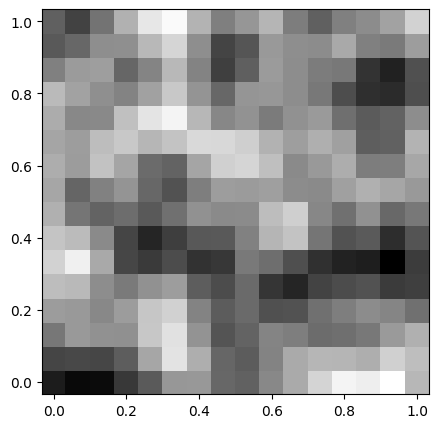

In [2]:
def generate_perlin_noise_field(
  octaves: int,
  persistence: float,
  lacunarity: float,
  scale: float,
  verbose: bool = False,
  seed: Optional[int] = None,
) -> CostFunction:
  if seed is not None:
    np.random.seed(seed)
  octave_seeds = np.random.randint(0, 1 << 32 - 1, size=(octaves,))
  octave_origins = np.random.uniform(size=(octaves,2))

  strength = 1
  frequency = scale

  result = 0
  x, y = sympy.symbols("x y")
  for seed, origin in tqdm(zip(octave_seeds, octave_origins), total=octaves, leave=False, disable=not verbose):
    result += noise2d(
      min_x = origin[0],
      max_x = frequency + origin[0],
      min_y = origin[1],
      max_y = frequency + origin[1],
      seed = seed,
      x=x*frequency + origin[0],
      y=y*frequency + origin[1],
    ) * strength

    strength *= persistence
    frequency *= lacunarity
  
  return result


if __name__ == "__main__":
  print("Generating octaves...")
  field = generate_perlin_noise_field(
    octaves=2,
    persistence=0.9,
    lacunarity=2,
    scale=3,
    verbose=True,
    seed=0
  )

  print("Sampling...")
  res = 16
  samples = np.empty((res, res))
  for v, u in tqdm(itertools.product(range(res), range(res)), total=res*res, leave=False):
    y = v/(res-1)
    x = u/(res-1)
    samples[v, u] = field.subs("x", x).subs("y", y)
  
  fig, ax = plt.subplots(figsize=(5, 5))

  ax.pcolor(np.linspace(0, 1, res), np.linspace(0, 1, res), samples, cmap="gray")

Generating octaves...


Sampling...


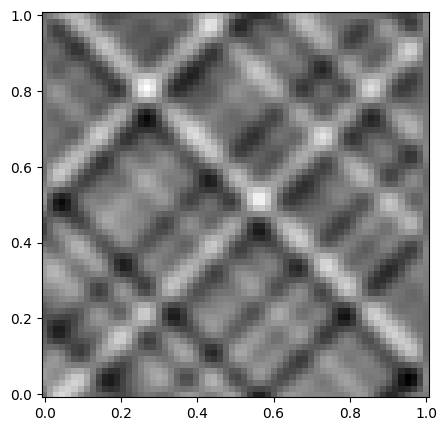

In [4]:
def generate_sine_noise_field(
  octaves: int,
  persistence: float,
  lacunarity: float,
  scale: float,
  verbose: bool = False,
  seed: Optional[int] = None,
) -> CostFunction:
  if seed is not None:
    np.random.seed(seed)
  octave_origins = np.random.uniform(0, 2*np.pi, size=(octaves,2))

  strength = 1
  frequency = scale

  result = 0
  x, y = sympy.symbols("x y")
  for origin in tqdm(octave_origins, leave=False, disable=not verbose):
    result += sine_noise(
      x_frequency = frequency,
      y_frequency = frequency,
      x_phase = origin[0],
      y_phase = origin[1],
      x=x,
      y=y,
    ) * strength

    strength *= persistence
    frequency *= lacunarity
  
  return result


if __name__ == "__main__":
  print("Generating octaves...")
  field = generate_sine_noise_field(
    octaves=5,
    persistence=0.9,
    lacunarity=1.3,
    scale=3,
    verbose=True,
    seed=0
  )

  print("Sampling...")
  res = 64
  samples = np.empty((res, res))
  for v, u in tqdm(itertools.product(range(res), range(res)), total=res*res, leave=False):
    y = v/(res-1)
    x = u/(res-1)
    samples[v, u] = field.subs("x", x).subs("y", y)
  
  fig, ax = plt.subplots(figsize=(5, 5))

  ax.pcolor(np.linspace(0, 1, res), np.linspace(0, 1, res), samples, cmap="gray")

In [5]:
def generate_random_instance(
  min_num_cities: int = 10,
  max_num_cities: int = 40,
) -> Instance:
  np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
  octaves = np.random.randint(1, 6)
  scale = np.random.uniform(0.5, 6)
  persistence = np.random.uniform(0.5, 1)
  lacunarity = np.random.uniform(1, 1.8)
  cost = generate_sine_noise_field(
    octaves=octaves,
    scale=scale,
    persistence=persistence,
    lacunarity=lacunarity,
    verbose=False
  )

  num_cities = np.random.randint(min_num_cities, max_num_cities+1)
  city_locations = list(tuple(x) for x in np.random.uniform(size=(num_cities, 2)))

  return (cost, city_locations)

In [6]:
if __name__ == "__main__":
  num_samples_to_generate = 10_000
  sample_instances_path = "sample_instances/"

  if not os.path.exists(sample_instances_path):
    os.makedirs(sample_instances_path)
  
  existing_samples = list(int(x[len("sample_"):-len(".dat")]) for x in os.listdir(sample_instances_path) if "sample_" in x)
  print(f"Loaded {len(existing_samples)} samples.")

  samples_to_generate = list(x for x in range(num_samples_to_generate) if x not in existing_samples)
  print(f"Generating {len(samples_to_generate)} samples...")

  def generate_sample_instance(i: int):
    sample = generate_random_instance()
    with open(os.path.join(sample_instances_path, f"sample_{i}.dat"), "wb") as fp:
      pickle.dump(sample, fp)
  
  with multiprocessing.Pool(10) as pool:
    list(tqdm(pool.imap_unordered(generate_sample_instance, samples_to_generate), total=len(samples_to_generate), leave=False))
    

Loaded 0 samples.
Generating 10000 samples...
